<a href="https://colab.research.google.com/github/galrat/parsing/blob/main/!patentability_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# установка пакетов

In [1]:
# установка пакетов

!pip install selenium
!pip install langid
from bs4 import BeautifulSoup
from google.colab import files

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.support.ui import WebDriverWait

import pandas as pd
import requests
import time

import re
import langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=87853287a6332c7a6b6d75203cfd4e816d19dcab23fed444b0d506b7416832ae
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


# Что нужно сделать для получения таблицы с патентами:
1. ниже надо ввести номера патентов для парсинга
2. затем нажать ctrl+F9 или выбрать Runtime->Run all в меню сверху

In [58]:
target_country = 'US'
title_filter_presence = []
title_filter_absence =  []
sequence_of_features = [['caterpillars'],
                        ['dirt'],
                        ['cleaning']
]

In [59]:
# original numbers for parsing

numbers = '''CN108564031A
CN105426843A
US10867159B2
'''


# основной код

## defs

In [60]:
def get_all_claims(soup):
  claims = soup.find('div', class_='layout horizontal style-scope patent-text').text
  return claims

In [61]:
def separate_languages(text):
    sentences = text.split('.')  # You can use a more sophisticated sentence tokenizer based on your text

    english_text = []
    other_languages_text = []

    for sentence in sentences:
        # Use langid to identify the language of each sentence
        lang, confidence = langid.classify(sentence)

        if lang == 'en':
            english_text.append(sentence)
        else:
            other_languages_text.append(sentence)

    return ' '.join(english_text)

In [62]:
def get_data_from_google_patent(url, target_country):
  options = Options()
  options.add_argument("--headless")
  options.add_argument('--no-sandbox')
  options.add_argument('--user-agent=Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36')
  driver = webdriver.Chrome(options=options)
  driver.get(url)
  WebDriverWait(driver, 20).until(ec.visibility_of_element_located((By.ID, 'content')))
  soup = BeautifulSoup(driver.page_source, 'lxml')

  # find US, EP, WO patent document

  others = soup.find('div', class_='event style-scope application-timeline')
  text = others.find_all(class_='style-scope application-timeline')[0]
  other_apps = ''
  for t in others.find_all(class_='style-scope application-timeline'):
      try:
        other_apps += t.get('data-result').split('patent/')[1].split('/')[0] + ','
      except:
        other_apps = other_apps
  print('other_apps', other_apps)

  if target_country not in url:
    new_app = ''
    for app_number in other_apps.split(','):
      #print('app_number', app_number)
      if 'US' in app_number:
        new_app = app_number
        break
      if 'EP' in app_number:
        new_app = app_number
        #break
      if 'WO' in app_number:
        new_app = app_number
        #break
    if new_app != '':
      url = 'https://patents.google.com/patent/' + new_app + '/en'
      print('new_url', url)
      options = Options()
      options.add_argument("--headless")
      options.add_argument('--no-sandbox')
      options.add_argument('--user-agent=Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36')
      driver = webdriver.Chrome(options=options)
      driver.get(url)
      WebDriverWait(driver, 20).until(ec.visibility_of_element_located((By.ID, 'content')))
      soup = BeautifulSoup(driver.page_source, 'lxml')
    else:
      print('url is not changed since no US, EP, WO is detected', url)
  else:
    print('url is not changed since it is target')

  # title
  title = soup.find('div', id='wrapper').find('h1', id='title').text.replace('\n', '').strip()
  #print('title:', title)

  # patent_number
  patent_number = soup.find('h2', id='pubnum').text.strip().replace('\n', '').replace('\t', '')
  #print('patent_number:', patent_number)

  # applicant
  author_counter = 0
  applicant_counter = 0
  counter = 0
  author_check = 0
  applicant_check = 0
  important_people_data = soup.find('dl', class_='important-people style-scope patent-result')
  for i in important_people_data.find_all('dt', class_='style-scope patent-result'):
      if 'Inventor' in i.text:
          author_counter = counter
          author_check = 1
      if 'assignee' in i.text:
          applicant_counter = counter
          applicant_check = 1
      counter += 1
  #print('author_counter', author_counter, 'applicant_counter', applicant_counter)

  authors = ''
  if author_check == 1:
      try:
          authors_data = soup.find('dl', class_='important-people style-scope patent-result')
          authors_data = authors_data.find_all('dt', class_='style-scope patent-result')[
              author_counter].find_next_siblings('dd')
          for author in authors_data:
              if '\n' in author.text:
                  break
              authors = authors + author.text + ';'
          authors = authors.replace('\n', '')
      except:
          #print('no authors data')
          authors = ('no authors data')
  else:
      authors = 'no_data'

  applicants = ''
  if applicant_check == 1:
      try:
          applicants_data = soup.find('dl', class_='important-people style-scope patent-result')
          applicants_data = applicants_data.find_all('dt', class_='style-scope patent-result')[
              applicant_counter].find_next_siblings('dd')
          for applicant in applicants_data:
              applicants = applicants + applicant.text.strip() + ';'
          applicants = applicants.replace('\n', '').strip()
      except:
          #print('no applicants data')
          applicants = ('no applicants data')
  else:
      applicants = 'no_data'

  # filing_date
  filind_date = 'no_data'
  publication_date = 'no_data'
  status = 'no_data'
  dates_data = soup.find_all('div', class_='event layout horizontal style-scope application-timeline')
  for data in dates_data:
      if 'filed by' in data.text:
          filind_date = data.text.split('Application')[0]
          #print('filing date:', filind_date)
      if 'Publication' in data.text:
          publication_date = data.text.split('Publication')[0]
          #print('publication date:', publication_date)
      if 'Status' in  data.text:
          status = data.text.split('Status')[1].replace('\n', '').replace('\t', '')
          #print('Status:', status)

  # application number
  try:
      application_number = soup.find_all('div', class_='header style-scope application-timeline')[1].text
      application_number = application_number.split('Application')[1].split('events')[0].replace(' ','')
  except:
      print('no application number data')
      application_number = 'no data'
  #print('application_number', application_number)

  # get priority applications
  priority_applications = ''
  for i in soup.find('div', class_='wrap style-scope application-timeline').find_all('div', class_='event layout horizontal style-scope application-timeline'):
    try:
      priority_applications += i.text.split('Priority to')[1].strip() + ';'
      #print(i.text.split('Priority to')[1].strip())
    except:
      no_priority = 1
  if priority_applications == '':
    priority_applications = 'no_data'

  # ipc
  ipc_data = 'no_data'
  try:
      ipcs = soup.find('div', class_='style-scope classification-viewer').find_all('div', class_='style-scope classification-tree')
      for ipc in ipcs:
          ipc_class = ipc.find(first=True).text.strip().replace('\n', '').replace('\t', '')
          #print('ipc', ipc_class)
      #print(ipc_class)
  except:
      ipc_data = 'no_data'

  ipc_datas = soup.find_all('div', class_='style-scope classification-tree')
  for i in ipc_datas[:1]:
      target = i.find_all(class_='code style-scope classification-tree')
      #print('target ipc', target[-1].text)
      # print(i.text.strip())
      ipc_data = target[-1].text

  # all claims
  claims = ''
  try:
    claims = soup.find('section', id='claims').text.strip()
    #print('claims google', claims)
  except:
    print('no claims')

  # descrition
  description = ''
  try:
    description = soup.find('section', id='description').text.strip().replace('\n\n', '\n')
    #print('descrition google', description)
  except:
    print('no description')

  # abstract
  abstract = ''
  try:
    abstract_orig = soup.find('section', id='abstract').find('span', class_='google-src-text style-scope patent-text').text#.text.replace('\n', '').replace('\t', '').replace('Abstracttranslated from ', '')
    #print('abstract_orig', abstract_orig)
    abstract_all = soup.find('section', id='abstract').text
    #print('abstract_all', abstract_all)
    abstract_eng = abstract_all.replace(abstract_orig, '').strip()
    abstract_eng = abstract_eng.replace('\n', '')
    #print('abstract_eng', abstract_eng)
    abstract = abstract_eng
  except:
    abstract = soup.find('section', id='abstract').text.replace('\n', '').replace('\t', ' ')


  # set 'printing = 1' to show info
  printing = 0
  if printing:
      print('patent_number:', patent_number)
      print('application_number:', application_number)
      print('title:', title)
      print('priority_applications:', priority_applications)
      print('filind_date:', filind_date)
      print('applicant:', applicants)
      print('authors:', authors)
      print('ipc_data:', ipc_data)
      print('publication_date:', publication_date)
      print('abstract:', abstract)
      print('claims:', claims)
      print('status:', status)
      print('others:', other_apps)
      print('description', description)


  header = ['patent number', 'application_number', 'title', 'INV/UM', 'filing_date', 'applicant', 'autors',
                          'publiction_date', 'ipc', 'claims', 'status', 'abstract', 'other_applications', 'description']
  data_line = []
  data_line.append(patent_number)
  data_line.append(application_number)
  data_line.append(title)
  data_line.append(priority_applications)
  data_line.append(filind_date)
  data_line.append(applicants)
  data_line.append(authors)
  data_line.append(publication_date)
  data_line.append(ipc_data)
  data_line.append(claims.replace('\n', ''))
  data_line.append(status)
  data_line.append(abstract.replace('\n', ''))
  #data_line.append(others[:-1])
  data_line.append(other_apps)
  data_line.append(description)

  # =========================================================================================
  # data from the bottom reagrding similar patents

  add_patents = soup.find('div', class_='footer style-scope patent-result').find_all('div', class_='responsive-table style-scope patent-result')[0].find_all('div', class_='tr style-scope patent-result')
  patent_lines = []
  for patent in add_patents:
    patent_line = []
    for line in patent.find_all('span'):
      #print(line.text.replace('*', '').strip())
      patent_line.append(line.text.replace('*', '').strip())
      #print('---------------------')
    #print(patent.find('span'))
    patent_lines.append(patent_line)
    #print('===========================')
    #break

  add_patents = soup.find('div', class_='footer style-scope patent-result').find_all('div', class_='responsive-table style-scope patent-result')[1].find_all('div', class_='tr style-scope patent-result')
  for patent in add_patents:
    patent_line = []
    for line in patent.find_all('span'):
      #print(line.text.replace('*', '').strip())
      patent_line.append(line.text.replace('*', '').strip())
      #print('---------------------')
    #print(patent.find('span'))
    if len(patent_line) == 3:
      patent_line.insert(1, 'no_data')
      patent_line.insert(3, 'no_data')
    patent_lines.append(patent_line)
    #print('===========================')
    #break

  add_patents = soup.find('div', class_='footer style-scope patent-result').find_all('div', class_='responsive-table style-scope patent-result')[2].find_all('div', class_='tr style-scope patent-result')
  for patent in add_patents:
    patent_line = []
    for line in patent.find_all('span'):
      #print(line.text.replace('*', '').strip())
      patent_line.append(line.text.replace('*', '').strip())

      #print('---------------------')
    #print(patent.find('span'))
    if len(patent_line) == 3:
      patent_line.insert(1, 'no_data')
      patent_line.insert(3, 'no_data')
    patent_lines.append(patent_line)
    #print('===========================')
    #break

  # get data for espacenet
  all_additional_urls = [url.get('href') for url in soup.find('dl', class_='links style-scope patent-result').findAll('a')]
  bottom_data = patent_lines

  return data_line, bottom_data, all_additional_urls


In [63]:
def get_patent_data(numbers, bottom_data_file):
  numbers = numbers.replace('-', '')
  all_numbers = numbers.split()
  print('lenght of all_numbers:', len(all_numbers))

  # проверка, какие номера патентов еще не спарсены
  file_for_saving_results = "/content/saved_data.txt"

  header_2 = ['patent number', 'application_number', 'title', 'priority applications', 'filing_date', 'applicant', 'authors',
                              'publiction_date', 'ipc', 'claims', 'status', 'abstract', 'other_applications', 'description']
  try:
      saved_data = pd.read_csv(file_for_saving_results, sep='\t')
      parsed_numbers = saved_data['original_number'].values
      #print('parsed_numbers', parsed_numbers)
  except:
      parsed_numbers = []
      with open(file_for_saving_results, 'a', encoding="utf-8") as file:
          file.writelines('\t'.join(['original_number'] + header_2) + '\n')
      print("creating new file")

  remaining_numbers = list(set(all_numbers) - set(parsed_numbers))
  print('remaining_numbers', remaining_numbers)
  print('total remaining', len(remaining_numbers))

  # correct app_numbers
  remaining_numbers_corrected = []
  for number in remaining_numbers:
      if number[:2] == 'WO' and len(number) == 12:
          number = 'WO20' + number[2:] + '/en'
      remaining_numbers_corrected.append(number)

  final_urls = []
  for app_num in remaining_numbers_corrected:
    if app_num[:3] == 'US2' and len(app_num) == 14:
        url =  app_num[:].replace('-', '')[:6] + '0' + app_num[:].replace('-', '')[6:] + '/en'
        url = 'https://patents.google.com/patent/' + url
        print('corrected url', url)
    else:
        url = 'https://patents.google.com/patent/' + app_num[:].replace('-', '').replace('\n', '') + '/en'
        print('url', url)
    final_urls.append(url)

  print('final_urls', final_urls)

  # результаты

  # get data by url
  print('\nstart of parsing')
  counter = 1
  parsed_data=[]
  wrong_numbers = []
  bottom_data = []
  espacenet_urls = []
  for original_number, url in zip(remaining_numbers, final_urls[:]):
    try:
      print(counter, '/', len(remaining_numbers))
      counter += 1
      print(url)
      data_line_google = get_data_from_google_patent(url, target_country)

      print('data_line_google[0]', data_line_google[0])
      print('data_line_google[1]', data_line_google[1])
      bottom_data += data_line_google[1]

      # get espacenet url
      all_additional_urls = data_line_google[2]

      parsed_data.append(data_line_google[0])
      with open(file_for_saving_results, 'a', encoding="utf-8") as file:
          file.writelines('\t'.join([original_number] + data_line_google[0]) + '\n')
          print('writing')
    except:
      wrong_numbers.append(original_number)
      print('smth wrong')


    print()
    #break
  print('====================finish=========================')
  print('wrong_numbers which shall be reparsed', wrong_numbers)

  # download the created file
  #files.download(file_for_saving_results)
  bottom_data_2 = []

  for line in bottom_data[1:]:
    if len(line) == 5 and 'Family To Family Citations' not in line[0] and 'Priority date' not in line[1]:
      bottom_data_2.append(line)

  bottom_data_df = pd.DataFrame(bottom_data_2[0:], columns=['publication number', 'Priority date', 'publication date',  'assignee',  'title'])
  #bottom_data_df.to_csv(bottom_data_file)
  #print(bottom_data_df)
  #files.download('bottom_data.csv')

  return parsed_data, bottom_data_df

## code

In [64]:
# первый этап, на котором парсятся номера патентов и собираются данные из bottom part (cited, citing, similar)
bottom_data_file = '/content/bottom_data_step_1.txt'
parsing_result = get_patent_data(numbers, bottom_data_file)
first_parsing_df = pd.DataFrame(parsing_result[0])


#first_step_data = pd.read_csv('/content/saved_data.txt', sep='\t')
print('количество документов на первом этапе', len(first_parsing_df))



lenght of all_numbers: 3
creating new file
remaining_numbers ['CN105426843A', 'CN108564031A', 'US10867159B2']
total remaining 3
url https://patents.google.com/patent/CN105426843A/en
url https://patents.google.com/patent/CN108564031A/en
url https://patents.google.com/patent/US10867159B2/en
final_urls ['https://patents.google.com/patent/CN105426843A/en', 'https://patents.google.com/patent/CN108564031A/en', 'https://patents.google.com/patent/US10867159B2/en']

start of parsing
1 / 3
https://patents.google.com/patent/CN105426843A/en
other_apps CN105426843B,
url is not changed since no US, EP, WO is detected https://patents.google.com/patent/CN105426843A/en
data_line_google[0] ['CN105426843A', 'CN201510801840.2A', 'Single-lens palm vein and palmprint image acquisition apparatus and image enhancement and segmentation method', 'CN201510801840.2A;', '2015-11-19', 'Anhui University;', '王华彬;郭婧宇;李俊林;李梦雯;石军;陶亮;', '2019-02-22', 'G06V40/13', 'Claims (10)                      Hide Dependent translate

In [65]:
columns = ['patent number', 'application_number', 'title', 'priority applications', 'filing_date', 'applicant', 'authors', 'publiction_date', 'ipc', 'claims', 'status', 'abstract', 'other_applications', 'description']
first_step_parsing_df = pd.DataFrame(parsing_result[0], columns=columns)
first_step_parsing_df

patent number application_number  \
0  CN105426843A  CN201510801840.2A   
1  CN108564031A  CN201810324828.0A   
2  US10867159B2       US16/262,032   

                                               title  \
0  Single-lens palm vein and palmprint image acqu...   
1  Single width near-infrared palm image-recogniz...   
2  Electronic device including palm biometric sen...   

        priority applications filing_date          applicant  \
0          CN201510801840.2A;  2015-11-19  Anhui University;   
1          CN201810324828.0A;  2018-04-12  Anhui University;   
2  US16/262,032;US17/092,609;  2019-01-30         Apple Inc;   

                                             authors publiction_date  \
0                             王华彬;郭婧宇;李俊林;李梦雯;石军;陶亮;      2019-02-22   
1                        王华彬;江晓龙;谢张宾;杜梦丽;余程年;陈昱翔;陶亮;      2018-09-21   
2  Dale R. Setlak;Giovanni Gozzini;Mohammad YEKE ...      2020-12-15   

           ipc                                             claims   status  \
0    G06V40/13  Claims (10)                      Hide Dependen...   Active   
1  G06V40/1347  Claims (6)                      Hide Dependent...  Pending   
2    G06F21/32  Claims (18)                      Hide Dependen...   Active   

                                            abstract  \
0  Abstracttranslated from The invention disclose...   
1  Abstracttranslated from The invention disclose...   
2  Abstracttranslated from An electronic device m...   

                                  other_applications  \
0                                      CN105426843B,   
1                                      CN108564031A,   
2  US10867159B2,WO2019173011A1,CN110245547B,CN110...   

                                         description  
0  Description\ntranslated from \n\n\n\n\n\nA kin...  
1  Description\ntranslated from \n\n\n\n\n\nSingl...  
2  Description\ntranslated from \n\n\n\n\n\nRELAT...

In [66]:
already_parsed = first_step_parsing_df['patent number'].values

In [67]:
cited_df = pd.DataFrame(parsing_result[1])
cited_df

publication number Priority date publication date  \
0        CN103116741A    2013-01-28       2013-05-22   
1     US20140019489A1    2012-07-10       2014-01-16   
2        CN104217195A    2014-08-07       2014-12-17   
3        CN106236016A    2016-08-18       2016-12-21   
4        CN107038445A    2017-02-13       2017-08-11   
5        CN107977935A    2017-11-15       2018-05-01   
6        CN109447052A    2019-01-09       2019-03-08   
7        CN111738076A    2020-05-18       2020-10-02   
8        CN112241720A    2020-10-27       2021-01-19   
9        CN112241721A    2020-10-27       2021-01-19   
10         TWI781459B    2020-10-08       2022-10-21   
11    US20120194662A1    2011-01-28       2012-08-02   
12       CN104318213A    2014-10-21       2015-01-28   
13       CN104951774A    2015-07-10       2015-09-30   
14       CN106022218A    2016-05-06       2016-10-12   
15       CN107195124A    2017-07-20       2017-09-22   
16       CN110163123A    2019-04-30       2019-08-23   
17       CN112241721A    2020-10-27       2021-01-19   
18        US6795569B1    1999-05-11       2004-09-21   
19    US20050148876A1    2002-09-03       2005-07-07   
20    US20100080422A1    2008-09-30       2010-04-01   
21        EP2477155A1    2009-09-11       2012-07-18   
22    US20130127980A1    2010-02-28       2013-05-23   
23    US20150347833A1    2014-06-03       2015-12-03   
24        EP3073414A1    2015-03-27       2016-09-28   
25    US20170262693A1    2016-03-10       2017-09-14   
26        US9792515B2    2013-03-26       2017-10-17   
27        US9792512B2    2013-07-30       2017-10-17   
28    US20180005005A1    2015-06-18       2018-01-04   
29    US20180150712A1    2016-11-28       2018-05-31   
30    US20180225498A1    2015-09-30       2018-08-09   
31       US10135822B2    2017-03-21       2018-11-20   
32       US10586092B2    2016-01-06       2020-03-10   
33       CN102402679A    2010-09-07       2012-04-04   
34        EP2704093A4    2011-04-22       2014-10-01   
35        JP6005750B2    2012-08-28       2016-10-12   
36      JP2015529365A    2012-09-05       2015-10-05   
37        JP5751269B2    2013-02-22       2015-07-22   
38     AU2014381638B2    2014-02-10       2018-03-08   
39        JP5991338B2    2014-03-31       2016-09-14   
40       US10867159B2    2018-03-09       2020-12-15   
41       US11587353B2    2018-03-09       2023-02-21   
42      KR102423231B1    2016-01-06       2022-07-22   
43      KR102135378B1    2018-08-06       2020-07-17   
44       CN111063078A    2019-11-20       2020-04-24   
45       US11615639B1    2021-01-27       2023-03-28   
46       CN117037221B    2023-10-08       2023-12-29   

                                assignee  \
0                                 天津理工大学   
1                            Jinjun Wang   
2                                 中国矿业大学   
3                           皖江新兴产业技术发展中心   
4                                   上海大学   
5                           合肥中科奔巴科技有限公司   
6                         东浓智能科技(上海)有限公司   
7                                   山东大学   
8                           上海掌腾信息科技有限公司   
9                           上海掌腾信息科技有限公司   
10                                國立中興大學   
11  The Hong Kong Polytechnic University   
12                                  沈阳大学   
13                                浙江工业大学   
14                                浙江工业大学   
15                                  长江大学   
16                              杭州电子科技大学   
17                          上海掌腾信息科技有限公司   
18                       Authentec, Inc.   
19                       Fujitsu Limited   
20                            Hideo Sato   
21                       Fujitsu Limited   
22                 Osterhout Group, Inc.   
23                    Mark Ries Robinson   
24                           Biowatch SA   
25                       Fujitsu Limited   
26                 Hyundai Motor Company   
27                       Fujitsu Limited   
28  Shenzhen GOODIX Technology Co., Lt

In [68]:
# обработка bottom file
df = cited_df
print('исходное количество bottom patents:', len(df))

df = df.drop_duplicates(['publication number'], keep='first')
df = df.dropna()
filtered_df = df[~df['publication number'].isin(already_parsed)]
print('первый этап фильтрации (drop_duplicates, dropna, drop already parsed)', len(filtered_df))

number_stop_words = [' et al.'] # to delete articles and save patents
#filtered_df = filtered_df[filtered_df['title'].str.contains('|'.join(title_filter_presence), case=False) & ~filtered_df['title'].str.contains('|'.join(title_filter_absence), case=False)]
filtered_df = filtered_df[~filtered_df['publication number'].str.contains('|'.join(number_stop_words), case=False)]
print('второй этап фильтрации (по ключевым словам в названии)', len(filtered_df))
#print(filtered_df[['publication number', 'title']])
print('отфильтрованы (исключены)', set(df['publication number'].values) - set(filtered_df['publication number'].values))
print()

pattern = r'^[A-Z]{2}'
filtered_df = filtered_df[filtered_df['publication number'].str.match(pattern)]
print(len(filtered_df))
#filtered_df['publication date'] = pd.to_datetime(filtered_df['publication date'])

filtered_df = filtered_df.sort_values('title', ascending=True)
#for i in range(len(filtered_df)):
  #print(filtered_df.iloc[i][['title']].values)

second_step_numbers = '\n'.join(filtered_df['publication number'].values)
#print('третий этап фильтрации (только целевая страна, только подходящая дата)', len(filtered_df['publication number'].values), '\n', second_step_numbers)


исходное количество bottom patents: 47
первый этап фильтрации (drop_duplicates, dropna, drop already parsed) 45
второй этап фильтрации (по ключевым словам в названии) 45
отфильтрованы (исключены) {'US10867159B2'}

45


In [69]:
second_step_for_parsing = '\n'.join(filtered_df['publication number'].values)

In [85]:
second_step_numbers = second_step_for_parsing[:] # здесь надо убрать 55
second_step_numbers

'EP3073414A1\nCN107038445A\nCN106236016A\nCN109447052A\nCN107977935A\nCN104217195A\nUS9792515B2\nKR102423231B1\nUS10586092B2\nJP6005750B2\nUS20170262693A1\nEP2477155A1\nUS10135822B2\nEP2704093A4\nCN103116741A\nUS20140019489A1\nUS9792512B2\nUS11587353B2\nCN111063078A\nUS20100080422A1\nUS20180225498A1\nUS6795569B1\nUS20180150712A1\nUS20050148876A1\nCN117037221B\nUS20120194662A1\nCN112241721A\nCN112241720A\nCN104318213A\nKR102135378B1\nAU2014381638B2\nCN111738076A\nCN102402679A\nUS20150347833A1\nCN110163123A\nCN106022218A\nCN104951774A\nTWI781459B\nUS11615639B1\nJP5991338B2\nJP5751269B2\nJP2015529365A\nCN107195124A\nUS20180005005A1\nUS20130127980A1'

In [86]:
# второй этап, на котором парсятся данные по номерам патентов из bottom part после первого парсинга

bottom_data_file_empty = '/content/bottom_data_step_empty.txt' # второй bottom data файл не используется, но его нужно указать
#print(second_step_numbers)
parsing_result_2 = get_patent_data(second_step_numbers, bottom_data_file_empty)


lenght of all_numbers: 45
remaining_numbers ['CN102402679A', 'US20180150712A1', 'AU2014381638B2', 'CN106022218A', 'US10586092B2', 'US20100080422A1', 'CN117037221B', 'TWI781459B', 'US20120194662A1', 'US20050148876A1', 'CN107195124A', 'US9792515B2', 'CN103116741A', 'US20180005005A1', 'KR102423231B1', 'CN110163123A', 'JP5751269B2', 'CN112241720A', 'EP3073414A1', 'CN109447052A', 'JP2015529365A', 'US20180225498A1', 'US20140019489A1', 'EP2477155A1', 'EP2704093A4', 'US9792512B2', 'US11615639B1', 'JP6005750B2', 'CN112241721A', 'CN107038445A', 'US20150347833A1', 'JP5991338B2', 'CN107977935A', 'US20130127980A1', 'CN106236016A', 'KR102135378B1', 'CN111738076A', 'CN104951774A', 'US10135822B2', 'US20170262693A1', 'US11587353B2', 'CN111063078A', 'US6795569B1', 'CN104318213A', 'CN104217195A']
total remaining 45
url https://patents.google.com/patent/CN102402679A/en
url https://patents.google.com/patent/US20180150712A1/en
url https://patents.google.com/patent/AU2014381638B2/en
url https://patents.googl

In [87]:
second_step_parsing_df = pd.DataFrame(parsing_result_2[0], columns=columns)
second_step_parsing_df

patent number application_number  \
0      CN102402679A   CN2010102764011A   
1   US20180150712A1       US15/803,972   
2   US20160357265A1       US15/117,692   
3      CN106022218A  CN201610298658.4A   
4      US10586092B2       US15/397,592   
5   US20100080422A1       US12/567,442   
6      CN117037221B  CN202311292964.3A   
7        TWI781459B       TW109135037A   
8   US20120194662A1       US13/015,581   
9   US20050148876A1       US11/046,698   
10     CN107195124A  CN201710597098.7A   
11      US9792515B2       US13/959,392   
12     CN103116741A   CN201310031696XA   
13  US20180005005A1       US15/708,088   
14     US10586092B2       US15/397,592   
15     CN110163123A  CN201910362774.1A   
16      JP5751269B2      JP2013032739A   
17     CN112241720A  CN202011160824.7A   
18      US9996758B2       US15/046,187   
19     CN109447052A  CN201910017879.3A   
20  US20140068740A1       US14/019,512   
21  US20180225498A1       US15/749,273   
22  US20140019489A1       US13/545,820   
23      US9373047B2       US13/416,379   
24  US20130329031A1       US14/001,235   
25      US9792512B2       US14/445,207   
26     US11615639B1       US17/160,130   
27  US20150324566A1       US14/424,213   
28     CN112241721A  CN202011160855.2A   
29     CN107038445A  CN201710076581.0A   
30  US20150347833A1       US14/730,218   
31      JP5991338B2      JP2014070865A   
32     CN107977935A  CN201711126132.9A   
33  US20130127980A1       US13/627,930   
34     CN106236016A  CN201610685272.9A   
35     US10970373B2       US16/422,697   
36     CN111738076A  CN202010419832.2A   
37     CN104951774A  CN201510407473.8A   
38     US10135822B2       US15/911,040   
39  US20170262693A1       US15/432,986   
40     US11587353B2       US17/092,609   
41     CN111063078A  CN201911139507.4A   
42      US6795569B1       US09/567,645   
43     CN104318213A  CN201410560835.2A   
44     CN104217195A  CN201410387933.0A   

                                                title  \
0   Non-contact type palm print and palm vein reco...   
1   Image processing apparatus, image processing m...   
2   Motion gesture input detected using optical se...   
3   Palm print palm vein image layer fusion method...   
4   Apparatus and method for user authentication, ...   
5   Finger Vein Authentication Apparatus and Finge...   
6   Living body detection method, living body dete...   
7   Palm vein feature identification system and me...   
8   Method and system for multispectral palmprint ...   
9                    Individual identification device   
10  The self-service book borrowing method in libr...   
11  Apparatus and method for recognizing stamped c...   
12  Capture and identification system for blending...   
13  Under-lcd screen optical sensor module for on-...   
14  Apparatus and method for user authentication, ...   
15  One kind referring to vein fusion identificati...   
16       Personal authentication apparatus and method   
17  Method for realizing palm vein image self-adap...   
18  Biometric sensor for detection of wrist blood ...   
19  A kind of vena metacarpea identification devic...   
20  System and method for biometric authentication...   
21  Finger biometric sensor for generating three d...   
22  Constructing Incremental Tree Model for Vein I...   
23  Biometric authentication device, biometric aut...   
24  Blood vessel image pickup device, and organism...   
25  Device to extract biometric feature vector, me...   
26  Palm vein identification apparatus and method ...   
27    Authentication Device and Authentication Method   
28  Method for realizing complete palm vein image ...   
29  A kind of binaryzation and dividing method for...   
30         Noncontact Biometrics with Small Footprint   
31       Personal authentication apparatus and method   
32  A kind of vena metacarpea image texture filter...   
33  Video display modification based on sensor inp...   
34  A kind of in-situ projection method for vein d...   
35  Mobile terminal a

In [88]:
# получаю большой df, оставляю в нем только номер, описание. Анализирую описание, чтобы найти абзацы с ключевыми словами. ключевые слова должны быть с OR и с AND.

In [89]:
first_step_parsing_df

patent number application_number  \
0  CN105426843A  CN201510801840.2A   
1  CN108564031A  CN201810324828.0A   
2  US10867159B2       US16/262,032   

                                               title  \
0  Single-lens palm vein and palmprint image acqu...   
1  Single width near-infrared palm image-recogniz...   
2  Electronic device including palm biometric sen...   

        priority applications filing_date          applicant  \
0          CN201510801840.2A;  2015-11-19  Anhui University;   
1          CN201810324828.0A;  2018-04-12  Anhui University;   
2  US16/262,032;US17/092,609;  2019-01-30         Apple Inc;   

                                             authors publiction_date  \
0                             王华彬;郭婧宇;李俊林;李梦雯;石军;陶亮;      2019-02-22   
1                        王华彬;江晓龙;谢张宾;杜梦丽;余程年;陈昱翔;陶亮;      2018-09-21   
2  Dale R. Setlak;Giovanni Gozzini;Mohammad YEKE ...      2020-12-15   

           ipc                                             claims   status  \
0    G06V40/13  Claims (10)                      Hide Dependen...   Active   
1  G06V40/1347  Claims (6)                      Hide Dependent...  Pending   
2    G06F21/32  Claims (18)                      Hide Dependen...   Active   

                                            abstract  \
0  Abstracttranslated from The invention disclose...   
1  Abstracttranslated from The invention disclose...   
2  Abstracttranslated from An electronic device m...   

                                  other_applications  \
0                                      CN105426843B,   
1                                      CN108564031A,   
2  US10867159B2,WO2019173011A1,CN110245547B,CN110...   

                                         description  
0  Description\ntranslated from \n\n\n\n\n\nA kin...  
1  Description\ntranslated from \n\n\n\n\n\nSingl...  
2  Description\ntranslated from \n\n\n\n\n\nRELAT...

In [90]:
merged_df = pd.concat([first_step_parsing_df, second_step_parsing_df])

merged_df

patent number application_number  \
0      CN105426843A  CN201510801840.2A   
1      CN108564031A  CN201810324828.0A   
2      US10867159B2       US16/262,032   
0      CN102402679A   CN2010102764011A   
1   US20180150712A1       US15/803,972   
2   US20160357265A1       US15/117,692   
3      CN106022218A  CN201610298658.4A   
4      US10586092B2       US15/397,592   
5   US20100080422A1       US12/567,442   
6      CN117037221B  CN202311292964.3A   
7        TWI781459B       TW109135037A   
8   US20120194662A1       US13/015,581   
9   US20050148876A1       US11/046,698   
10     CN107195124A  CN201710597098.7A   
11      US9792515B2       US13/959,392   
12     CN103116741A   CN201310031696XA   
13  US20180005005A1       US15/708,088   
14     US10586092B2       US15/397,592   
15     CN110163123A  CN201910362774.1A   
16      JP5751269B2      JP2013032739A   
17     CN112241720A  CN202011160824.7A   
18      US9996758B2       US15/046,187   
19     CN109447052A  CN201910017879.3A   
20  US20140068740A1       US14/019,512   
21  US20180225498A1       US15/749,273   
22  US20140019489A1       US13/545,820   
23      US9373047B2       US13/416,379   
24  US20130329031A1       US14/001,235   
25      US9792512B2       US14/445,207   
26     US11615639B1       US17/160,130   
27  US20150324566A1       US14/424,213   
28     CN112241721A  CN202011160855.2A   
29     CN107038445A  CN201710076581.0A   
30  US20150347833A1       US14/730,218   
31      JP5991338B2      JP2014070865A   
32     CN107977935A  CN201711126132.9A   
33  US20130127980A1       US13/627,930   
34     CN106236016A  CN201610685272.9A   
35     US10970373B2       US16/422,697   
36     CN111738076A  CN202010419832.2A   
37     CN104951774A  CN201510407473.8A   
38     US10135822B2       US15/911,040   
39  US20170262693A1       US15/432,986   
40     US11587353B2       US17/092,609   
41     CN111063078A  CN201911139507.4A   
42      US6795569B1       US09/567,645   
43     CN104318213A  CN201410560835.2A   
44     CN104217195A  CN201410387933.0A   

                                                title  \
0   Single-lens palm vein and palmprint image acqu...   
1   Single width near-infrared palm image-recogniz...   
2   Electronic device including palm biometric sen...   
0   Non-contact type palm print and palm vein reco...   
1   Image processing apparatus, image processing m...   
2   Motion gesture input detected using optical se...   
3   Palm print palm vein image layer fusion method...   
4   Apparatus and method for user authentication, ...   
5   Finger Vein Authentication Apparatus and Finge...   
6   Living body detection method, living body dete...   
7   Palm vein feature identification system and me...   
8   Method and system for multispectral palmprint ...   
9                    Individual identification device   
10  The self-service book borrowing method in libr...   
11  Apparatus and method for recognizing stamped c...   
12  Capture and identification system for blending...   
13  Under-lcd screen optical sensor module for on-...   
14  Apparatus and method for user authentication, ...   
15  One kind referring to vein fusion identificati...   
16       Personal authentication apparatus and method   
17  Method for realizing palm vein image self-adap...   
18  Biometric sensor for detection of wrist blood ...   
19  A kind of vena metacarpea identification devic...   
20  System and method for biometric authentication...   
21  Finger biometric sensor for generating three d...   
22  Constructing Incremental Tree Model for Vein I...   
23  Biometric authentication device, biometric aut...   
24  Blood vessel image pickup device, and organism...   
25  Device to extract biometric feature vector, me...   
26  Palm vein identification apparatus and method ...   
27    Authentication Device and Authentication Method   
28  Method for realizing complete palm vein image ...   
29  A kind of binaryzation and dividing method for...   
30       

In [107]:
import pickle
with open('/content/merged_df_2.pkl', 'wb') as f:
  pickle.dump(merged_df, f)

In [106]:
with open('/content/merged_df_2.pkl', 'rb') as file:
  merged_df = pickle.load(file)


In [108]:
novelty_df = merged_df[['patent number', 'description']]
novelty_df

patent number                                        description
0      CN105426843A  Description\ntranslated from \n\n\n\n\n\nA kin...
1      CN108564031A  Description\ntranslated from \n\n\n\n\n\nSingl...
2      US10867159B2  Description\ntranslated from \n\n\n\n\n\nRELAT...
0      CN102402679A  Description\ntranslated from \n\n\n\n\n\nConta...
1   US20180150712A1  Description\ntranslated from \n\n\n\n\n\nCROSS...
2   US20160357265A1  Description\ntranslated from \n\n\n\n\n\nFIELD...
3      CN106022218A  Description\ntranslated from \n\n\n\n\n\nA kin...
4      US10586092B2  Description\ntranslated from \n\n\n\n\n\nRELAT...
5   US20100080422A1  Description\ntranslated from \n\n\n\n\n\nBACKG...
6      CN117037221B  Description\ntranslated from \n\n\n\n\n\nLivin...
7        TWI781459B  Description\ntranslated from Chinese\n\n\n\n\n...
8   US20120194662A1  Description\ntranslated from \n\n\n\n\n\nBACKG...
9   US20050148876A1  Description\ntranslated from \n\n\n\n\n\nCROSS...
10     CN107195124A  Description\ntranslated from \n\n\n\n\n\nThe s...
11      US9792515B2  Description\ntranslated from \n\n\n\n\n\nCROSS...
12     CN103116741A  Description\ntranslated from \n\n\n\n\n\nThe c...
13  US20180005005A1  Description\ntranslated from \n\n\n\n\n\nCROSS...
14     US10586092B2  Description\ntranslated from \n\n\n\n\n\nRELAT...
15     CN110163123A  Description\ntranslated from \n\n\n\n\n\nOne k...
16      JP5751269B2  Description\ntranslated from Japanese\n\n\n\n\...
17     CN112241720A  Description\ntranslated from \n\n\n\n\n\nMetho...
18      US9996758B2  Description\ntranslated from \n\n\n\n\n\nRELAT...
19     CN109447052A  Description\ntranslated from \n\n\n\n\n\nA kin...
20  US20140068740A1  Description\ntranslated from \n\n\n\n\n\nCROSS...
21  US20180225498A1  Description\ntranslated from \n\n\n\n\n\nTECHN...
22  US20140019489A1  Description\ntranslated from \n\n\n\n\n\nBACKG...
23      US9373047B2  Description\ntranslated from \n\n\n\n\n\nCROSS...
24  US20130329031A1  Description\ntranslated from \n\n\n\n\n\nTECHN...
25      US9792512B2  Description\ntranslated from \n\n\n\n\n\nCROSS...
26     US11615639B1  Description\ntranslated from \n\n\n\n\n\n BACK...
27  US20150324566A1  Description\ntranslated from \n\n\n\n\n\nTECHN...
28     CN112241721A  Description\ntranslated from \n\n\n\n\n\nMetho...
29     CN107038445A  Description\ntranslated from \n\n\n\n\n\nA kin...
30  US20150347833A1  Description\ntranslated from \n\n\n\n\n\nCROSS...
31      JP5991338B2  Description\ntranslated from Japanese\n\n\n\n\...
32     CN107977935A  Description\ntranslated from \n\n\n\n\n\nA kin...
33  US20130127980A1  Description\ntranslated from \n\n\n\n\n\nCROSS...
34     CN106236016A  Description\ntranslated from \n\n\n\n\n\nA kin...
35     US10970373B2  Description\ntranslated from \n\n\n\n\n\nCROSS...
36     CN111738076A  Description\ntranslated from \n\n\n\n\n\nNon-c...
37     CN104951774A  Description\ntranslated from \n\n\n\n\n\nBased...
38     US10135822B2  Description\ntranslated from \n\n\n\n\n\nCROSS...
39  US20170262693A1  Description\ntranslated from \n\n\n\n\n\nCROSS...
40     US11587353B2  Description\ntranslated from \n\n\n\n\n\nRELAT...
41     CN111063078A  Description\ntranslated from \n\n\n\n\n\nEntra...
42      US6795569B1  Description\ntranslated from \n\n\n\n\n\nRELAT...
43     CN104318213A  Description\ntranslated from \n\n\n\n\n\nA kin...
44     CN104217195A  Description\ntranslated from \n\n\n\n\n\nHand ...

In [139]:
from itertools import product
import re

def get_word_combinations(list_of_strings):
    # Split each string into words
    words_lists = [string.split(" OR ") for string in list_of_strings]

    # Generate all combinations of words
    combinations = list(product(*words_lists))
    #print('combinations', combinations)
    # Join each combination into a single string
    combinations_strings = [' '.join(combination) for combination in combinations]

    return combinations



def find_sentences_with_words(text, word_list):
    # Split text into sentences
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    sentences = re.split(r'[.\n]', text)
    #print('sentences', sentences, 'word_list', word_list)
    # Initialize a list to store sentences containing all words
    result_sentences = []

    # Check each sentence
    for sentence in sentences:
        #print('sentence', sentence)
        if all(word.lower() in sentence.lower() for word in word_list):
            result_sentences.append(sentence)
            #print('+')

    return result_sentences

In [157]:
filter_data = [
              ['vena'],
              ['palm'],
              ['palmprint', 'image'],
              ['invention'],
              ['palmprint', 'identification OR imaging'],
              ['iris']
              ]
combinations = []
for i in filter_data:
  #print(get_word_combinations(i))
  combinations += (get_word_combinations(i))
combinations

[('vena',),
 ('palm',),
 ('palmprint', 'image'),
 ('invention',),
 ('palmprint', 'identification'),
 ('palmprint', 'imaging'),
 ('iris',)]

In [186]:
def capitalize_words(sentence, word_list):
    words = sentence.split()
    for i, word in enumerate(words):
        # Check if any word in list A is part of the current word
        if any(item in word.lower() for item in word_list):
            words[i] = word.upper()
    return ' '.join(words)

# Capitalize words in each sentence based on list A


In [190]:
final_results = []
for patent_number, description in zip(novelty_df['patent number'].values, novelty_df['description'].values):
  print(patent_number)
  results = []
  for combination in combinations:
    print(list(combination))
    result = find_sentences_with_words(description[:1000], list(combination))
    if result == []:
      result = ''
    capitalized_sentences = [capitalize_words(sentence, list(combination)) for sentence in result]
    results.append(capitalized_sentences)
    print("Sentences containing all words:", capitalized_sentences)
  final_results.append([patent_number] + results)
  break
final_results

CN105426843A
['vena']
Sentences containing all words: ['A kind of single-lens lower VENA metacarpea and palmprint image collecting device and image enhaucament and dividing method', 'The present invention relates to living things feature recognition field, be specially a kind of device using single camera lens simultaneously to gather palm vein image and palmprint image, the invention still further relates to enhancing and the dividing method of a kind of low contrast VENA metacarpea and palmprint image']
['palm']
Sentences containing all words: ['A kind of single-lens lower vena metacarpea and PALMPRINT image collecting device and image enhaucament and dividing method', 'The present invention relates to living things feature recognition field, be specially a kind of device using single camera lens simultaneously to gather PALM vein image and PALMPRINT image, the invention still further relates to enhancing and the dividing method of a kind of low contrast vena metacarpea and PALMPRINT

[['CN105426843A',
  ['A kind of single-lens lower VENA metacarpea and palmprint image collecting device and image enhaucament and dividing method',
   'The present invention relates to living things feature recognition field, be specially a kind of device using single camera lens simultaneously to gather palm vein image and palmprint image, the invention still further relates to enhancing and the dividing method of a kind of low contrast VENA metacarpea and palmprint image'],
  ['A kind of single-lens lower vena metacarpea and PALMPRINT image collecting device and image enhaucament and dividing method',
   'The present invention relates to living things feature recognition field, be specially a kind of device using single camera lens simultaneously to gather PALM vein image and PALMPRINT image, the invention still further relates to enhancing and the dividing method of a kind of low contrast vena metacarpea and PALMPRINT image',
   'Current, comparative maturity and several biometrics 

In [183]:
result

''

In [ ]:
visualization_df = pd.DataFrame(final_results, columns=['patent number'] + combinations)
visualization_df

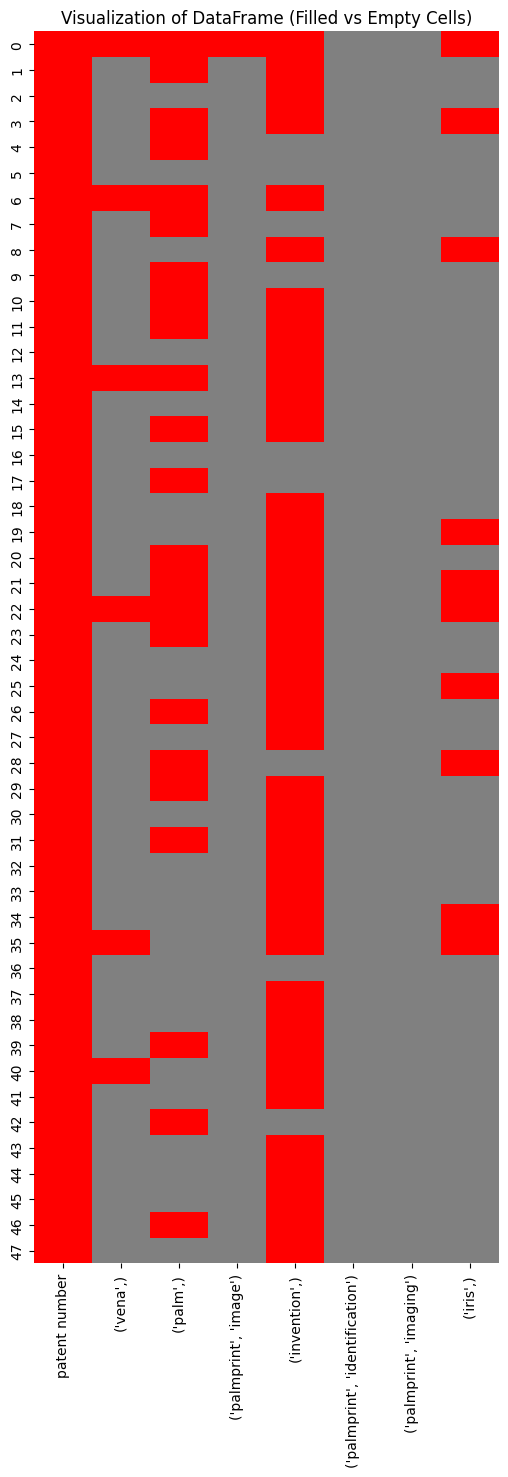

In [179]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
data = {'A': [1, np.nan, 3, np.nan],
        'B': ['a', 'b', np.nan, 'd'],
        'C': [np.nan, 'x', 'y', 'z']}
df = visualization_df

# Replace empty cells with NaN
df_nan = df.replace('', np.nan)

# Generate a heatmap with seaborn
plt.figure(figsize=(6, 16))
sns.heatmap(df_nan.isnull(), cmap=['red', 'grey'], cbar=False)
plt.title('Visualization of DataFrame (Filled vs Empty Cells)')
plt.show()

In [180]:
visualization_df.to_csv('/content/final_data.csv')

In [94]:
import re

def get_sentenses_with_terms(sentences, target_words_or_line, target_words_and_line):
  all_sentenses = ''
  # Split the target words lines into individual target words
  target_words_or = target_words_or_line.split(" OR ")
  target_words_and = target_words_and_line.split(" AND ")

  # Function to check if a sentence meets the conditions

  def meets_conditions2(sentence):
    # Check if the sentence contains any of the target words from the first line
    if not any(word in sentence for word in target_words_or):
        return False
    # Check if the sentence contains all the target words from the second line
    if not all(word in sentence for word in target_words_and):
        return False
    return True


  # Filter sentences based on target words
  filtered_sentences = [sentence for sentence in sentences if meets_conditions2(sentence.lower())]
  #print('filtered_sentences', filtered_sentences)

  # Print the filtered sentences
  for sentence in filtered_sentences:
      #print('sentence', sentence)
      all_sentenses += sentence + '.\n'
  #print(all_sentenses)
  return all_sentenses

In [95]:
filter_data = [
              {'target_words_or': 'dirt OR snow',
               'target_words_and': 'clean AND clean'},

              {'target_words_or':'smth OR snow',
               'target_words_and': 'test AND test'},

              {'target_words_or':'else OR snow',
               'target_words_and': 'easy'},

               {'target_words_or': 'dirt OR snow',
               'target_words_and': 'clean'},

              {'target_words_or': 'caterpillar',
               'target_words_and': ''}

               ]
novelty_columns = []
for i in filter_data:
  novelty_column = ''
  for j in i.values():
    #print(j)
    novelty_column += j + ' + '
  novelty_columns.append('!' + novelty_column[:-2] + '!' )


In [96]:
patent_lines = []
for patents_iter in range(len(novelty_df)):
  print(patents_iter, novelty_df['patent number'].values[patents_iter])
  patent_line = []
  for iter in filter_data:
    #print(iter)
    #print(iter['target_words_or'], ',', iter['target_words_and'])
    target_parts = get_sentenses_with_terms(re.split(r'[.\n]', novelty_df.description.values[patents_iter]), iter['target_words_or'], iter['target_words_and'])
    #print('target_parts', target_parts, '--------------')
    #print("[novelty_df['patent number'].values[patents_iter]]", novelty_df['patent number'].values[patents_iter])
    patent_line.append(target_parts)
    #print('patent_line', patent_line)

  patent_lines.append([novelty_df['patent number'].values[patents_iter]] + patent_line)

  #break

0 CN105426843A
1 CN108564031A
2 US10867159B2
3 CN102402679A
4 US20180150712A1
5 US20160357265A1
6 CN106022218A
7 US10586092B2
8 US20100080422A1
9 CN117037221B
10 TWI781459B
11 US20120194662A1
12 US20050148876A1
13 CN107195124A
14 US9792515B2
15 CN103116741A
16 US20180005005A1
17 US10586092B2
18 CN110163123A
19 JP5751269B2
20 CN112241720A
21 US9996758B2
22 CN109447052A
23 US20140068740A1
24 US20180225498A1
25 US20140019489A1
26 US9373047B2
27 US20130329031A1
28 US9792512B2
29 US11615639B1
30 US20150324566A1
31 CN112241721A
32 CN107038445A
33 US20150347833A1
34 JP5991338B2
35 CN107977935A
36 US20130127980A1
37 CN106236016A
38 US10970373B2
39 CN111738076A
40 CN104951774A
41 US10135822B2
42 US20170262693A1
43 US11587353B2
44 CN111063078A
45 US6795569B1
46 CN104318213A
47 CN104217195A


In [97]:
novelty_analysis_df = pd.DataFrame(patent_lines, columns=['patent_number'] + novelty_columns)
novelty_analysis_df

patent_number !dirt OR snow + clean AND clean !  \
0      CN105426843A                                     
1      CN108564031A                                     
2      US10867159B2                                     
3      CN102402679A                                     
4   US20180150712A1                                     
5   US20160357265A1                                     
6      CN106022218A                                     
7      US10586092B2                                     
8   US20100080422A1                                     
9      CN117037221B                                     
10       TWI781459B                                     
11  US20120194662A1                                     
12  US20050148876A1                                     
13     CN107195124A                                     
14      US9792515B2                                     
15     CN103116741A                                     
16  US20180005005A1                                     
17     US10586092B2                                     
18     CN110163123A                                     
19      JP5751269B2                                     
20     CN112241720A                                     
21      US9996758B2                                     
22     CN109447052A                                     
23  US20140068740A1                                     
24  US20180225498A1                                     
25  US20140019489A1                                     
26      US9373047B2                                     
27  US20130329031A1                                     
28      US9792512B2                                     
29     US11615639B1                                     
30  US20150324566A1                                     
31     CN112241721A                                     
32     CN107038445A                                     
33  US20150347833A1                                     
34      JP5991338B2                                     
35     CN107977935A                                     
36  US20130127980A1                                     
37     CN106236016A                                     
38     US10970373B2                                     
39     CN111738076A                                     
40     CN104951774A                                     
41     US10135822B2                                     
42  US20170262693A1                                     
43     US11587353B2                                     
44     CN111063078A                                     
45      US6795569B1                                     
46     CN104318213A                                     
47     CN104217195A                                     

                      !smth OR snow + test AND test ! !else OR snow + easy !  \
0                                                                              
1                                                                              
2                                                                              
3                                                                              
4                                                                              
5                                                                              
6                                                                              
7                                                                              
8                                                                              
9                                                                              
10                                                                             
11                                                                             
12                                                                             
13                                                                             
14          

In [98]:
novelty_analysis_df.to_csv('/content/novelty.csv')

In [99]:
  for iter in filter_data:
    print(iter)
    #print(iter['target_words_or'], ',', iter['target_words_and'])
    target_parts = get_sentenses_with_terms(re.split(r'[.\n]', novelty_df.description.values[0]), iter['target_words_or'], iter['target_words_and'])
    #print(target_parts)
    print()
    patent_line = [novelty_df['patent number'][3]] + [target_parts]
    #print(patent_line)


{'target_words_or': 'dirt OR snow', 'target_words_and': 'clean AND clean'}

{'target_words_or': 'smth OR snow', 'target_words_and': 'test AND test'}

{'target_words_or': 'else OR snow', 'target_words_and': 'easy'}

{'target_words_or': 'dirt OR snow', 'target_words_and': 'clean'}

{'target_words_or': 'caterpillar', 'target_words_and': ''}



In [ ]:
patent_lines

# tests part
